In [2]:
pip install contractions


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 12.1 MB/s eta 0:00:00


In [9]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
!pip install nltk

In [12]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Epoch 1/5
279/279 [==============================] - 14s 43ms/step - loss: 0.1909 - accuracy: 0.9430 - val_loss: 0.0624 - val_accuracy: 0.9830
Epoch 2/5
279/279 [==============================] - 11s 38ms/step - loss: 0.0391 - accuracy: 0.9908 - val_loss: 0.0644 - val_accuracy: 0.9776
Epoch 3/5
279/279 [==============================] - 10s 36ms/step - loss: 0.0172 - accuracy: 0.9955 - val_loss: 0.0742 - val_accuracy: 0.9839
Epoch 4/5
279/279 [==============================] - 11s 39ms/step - loss: 0.0101 - accuracy: 0.9973 - val_loss: 0.0702 - val_accuracy: 0.9839
Epoch 5/5
279/279 [==============================] - 12s 41ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 0.0821 - val_accuracy: 0.9830


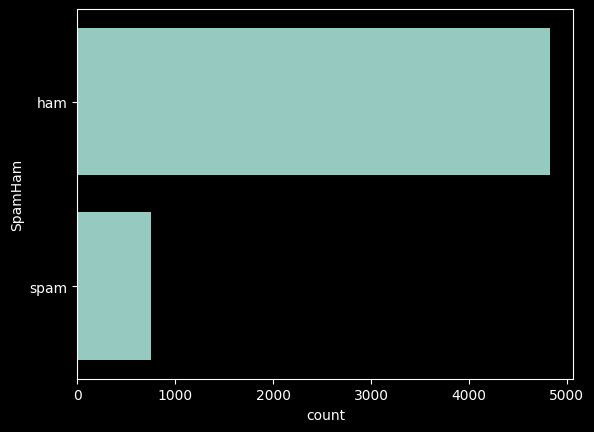

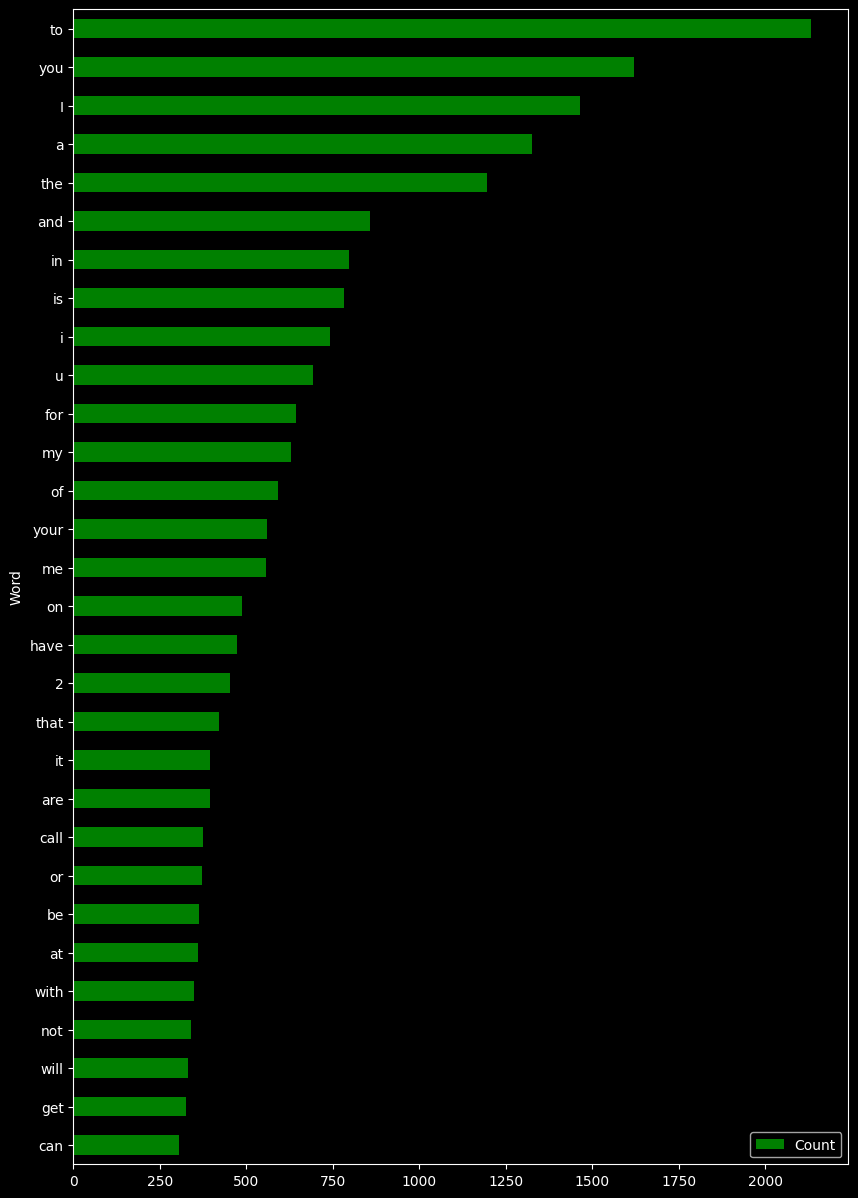

In [13]:
import pandas as pd
import numpy as np
import re
import collections
import contractions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle
from sklearn.preprocessing import LabelEncoder

# Importing the SMS spam detection dataset
df = pd.read_csv("/content/drive/MyDrive/spam.csv", encoding='latin-1')
df
df = df[['v1', 'v2']]
df.columns = ["SpamHam","Tweet"]

# Plot the value counts of both spam and ham SMS
sns.countplot(df["SpamHam"])

# Define a function to plot word count
def word_count_plot(data):
    word_counter = collections.Counter([word for sentence in data for word in sentence.split()])
    most_count = word_counter.most_common(30)
    most_count = pd.DataFrame(most_count, columns=["Word", "Count"]).sort_values(by="Count")
    most_count.plot.barh(x = "Word", y = "Count", color="green", figsize=(10, 15))

word_count_plot(df["Tweet"])

# Define preprocessing function
lem = WordNetLemmatizer()
def preprocessing(data):
    sms = contractions.fix(data)
    sms = sms.lower()
    sms = re.sub(r'https?://S+|www.S+', "", sms).strip()
    sms = re.sub("[^a-z ]", "", sms)
    sms = sms.split()
    sms = [lem.lemmatize(word) for word in sms if not word in set(stopwords.words("english"))]
    sms = " ".join(sms)
    return sms

X = df["Tweet"].apply(preprocessing)

# Convert output feature into numerical form
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(df["SpamHam"])

# Tokenize data and convert it into numerical sequence
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
text_to_sequence = tokenizer.texts_to_sequences(X)

# Pad sequences
max_length_sequence = max([len(i) for i in text_to_sequence])
padded_sms_sequence = pad_sequences(text_to_sequence, maxlen=max_length_sequence, padding="pre")

# Define LSTM model
TOT_SIZE = len(tokenizer.word_index) + 1
def create_model():
    lstm_model = Sequential()
    lstm_model.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
    lstm_model.add(LSTM(100))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20, activation="relu"))
    lstm_model.add(Dropout(0.3))
    lstm_model.add(Dense(1, activation="sigmoid"))
    return lstm_model

lstm_model = create_model()
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
lstm_model.fit(padded_sms_sequence, y, epochs=5, validation_split=0.2, batch_size=16)

# Save model and tokenizer
pickle.dump(tokenizer, open("sms_spam_tokenizer.pkl", "wb"))
pickle.dump(lstm_model, open("lstm_model.pkl", "wb"))


In [24]:
# Define the maximum sequence length
max_length_sequence = 100  # You can set this to the maximum sequence length used during training

def predict_spam(text):
    # Preprocess the text
    preprocessed_text = preprocessing(text)

    # Convert the preprocessed text to a sequence
    text_sequence = tokenizer.texts_to_sequences([preprocessed_text])

    # Pad the sequence
    padded_text_sequence = pad_sequences(text_sequence, maxlen=max_length_sequence, padding="pre")

    # Predict the class (spam or not spam)
    prediction = lstm_model.predict(padded_text_sequence)[0][0]

    # Convert the prediction to a binary label
    if prediction >= 0.5:
        label = "Spam"
    else:
        label = "Ham"

    # Return the prediction and label
    return prediction, label

# Get user input
user_text = input("Enter your text: ")

# Predict the spam probability and label
prediction, label = predict_spam(user_text)

# Print the results
print(f"Prediction: {prediction:.2f}")
print(f"Label: {label}")


Enter your text: Win up to Rs. 1,00,00,000* (1 Crore).  Dear 918248762314,  Win up to Rs. 1,00,00,000* (1 Crore) on Junglee Rummy!  Get up to Rs. 8850* Welcome Bonus in your  Junglee Rummy account 70+ Million Players.  Quick Cash Withdrawal.  Safe, Secure & Exciting.  T&C
1/1 [==============================] - 0s 27ms/step
Prediction: 0.70
Label: Spam
